In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from sklearn import metrics, model_selection as ms, neighbors
from sklearn import linear_model

### Understanding Data

In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies = movies[['budget', 'revenue', 'genres', 'keywords', 'runtime', 'title', 'popularity', 'vote_count', 'vote_average']]
movies.head()

,budget,revenue,genres,keywords,runtime,title,popularity,vote_count,vote_average
0,237000000,2787965087,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",162.0,Avatar,150.437577,11800,7.2
1,300000000,961000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",169.0,Pirates of the Caribbean: At World's End,139.082615,4500,6.9
2,245000000,880674609,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",148.0,Spectre,107.376788,4466,6.3
3,250000000,1084939099,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",165.0,The Dark Knight Rises,112.312950,9106,7.6
4,260000000,284139100,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",132.0,John Carter,43.926995,2124,6.1


In [3]:
movies = movies.set_index('title')
movies.drop(columns=['revenue'], inplace=True)

In [4]:
# missing data
total = movies.isnull().sum().sort_values(ascending=False)
percent = (movies.isnull().sum()/movies.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
runtime,2,0.000416
vote_average,0,0.000000
vote_count,0,0.000000
popularity,0,0.000000
keywords,0,0.000000


In [5]:
movies.shape

(4803, 7)

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4803 entries, Avatar to My Date with Drew
Data columns (total 7 columns):
budget          4803 non-null int64
genres          4803 non-null object
keywords        4803 non-null object
runtime         4801 non-null float64
popularity      4803 non-null float64
vote_count      4803 non-null int64
vote_average    4803 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 300.2+ KB


In [7]:
# independent variables : profits, genre, keywords, runtime, vote_count
# dependent variables   : popularity, vote_average

In [8]:
movies.describe()

,budget,runtime,popularity,vote_count,vote_average
count,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,106.875859,21.492301,690.217989,6.092172
std,4.072239e+07,22.611935,31.816650,1234.585891,1.194612
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,94.000000,4.668070,54.000000,5.600000
50%,1.500000e+07,103.000000,12.921594,235.000000,6.200000
75%,4.000000e+07,118.000000,28.313505,737.000000,6.800000
max,3.800000e+08,338.000000,875.581305,13752.000000,10.000000


In [9]:
movies = movies.query('1000 < budget < 100000000')
movies = movies.query('vote_count < 2000')
movies = movies.query('popularity < 100')
movies = movies.query('vote_average < 9.9')
movies.describe()

,budget,runtime,popularity,vote_count,vote_average
count,3.163000e+03,3162.000000,3163.000000,3163.000000,3163.000000
mean,2.577806e+07,107.574636,18.036683,439.335441,6.145210
std,2.297265e+07,19.877678,14.183355,451.406574,0.925456
min,7.000000e+03,0.000000,0.001586,0.000000,0.000000
25%,7.000000e+06,95.000000,6.923985,93.000000,5.600000
50%,2.000000e+07,104.000000,14.672151,280.000000,6.200000
75%,4.000000e+07,117.000000,25.944331,640.000000,6.800000
max,9.900000e+07,338.000000,85.428395,1999.000000,8.500000


### Genres and Keywords

In [10]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

movies['genres'] = movies['genres'].apply(json.loads).apply(pipe_flatten_names)
movies['keywords'] = movies['keywords'].apply(json.loads).apply(pipe_flatten_names)
movies[['genres', 'keywords']].head()

,genres,keywords
title,,
The Lovers,Action|Adventure|Science Fiction|Romance,
Shin Godzilla,Action|Adventure|Drama|Horror|Science Fiction,monster|godzilla|giant monster|destruction|kai...
Beowulf,Adventure|Action|Animation,denmark|nordic mythology|lie|pride and vanity|...
Total Recall,Action|Adventure|Science Fiction,oxygen|falsely accused|resistance|mars|double ...
Asterix at the Olympic Games,Fantasy|Adventure|Comedy|Family,competition|greece|colosseum|olympic games|emp...


### Understanding Correlations

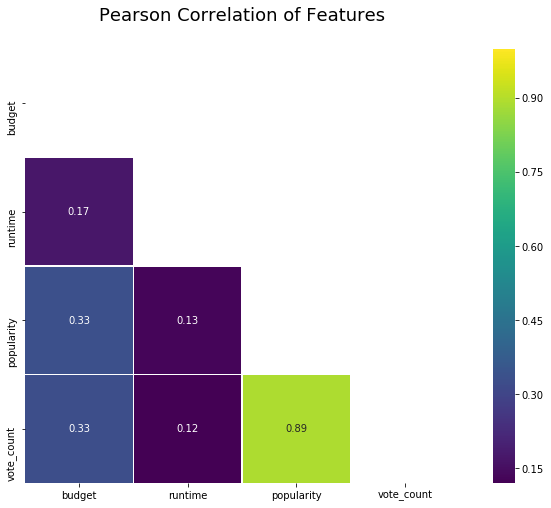

In [11]:
corr = movies.drop(['genres', 'keywords', 'vote_average'], 1).astype(float).corr()
plt.figure(figsize=(12,8))
plt.title('Pearson Correlation of Features', y=1.05, size=18)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    linewidths=0.1,
    mask=mask, 
    vmax=1.0, 
    square=True, 
    cmap=plt.cm.viridis,
    annot=True
)
plt.show()

In [12]:
# Here, popularity shows high positive correlation with vote count
# hence we will just be using vote count as a determining factor and ignoring popularity

movies.drop(['popularity'], axis=1, inplace=True)

C:\Users\jwcn9\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x720 with 0 Axes>

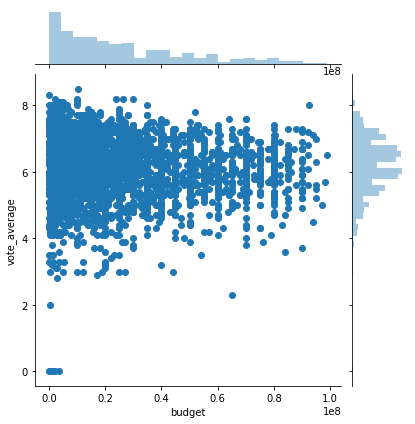

In [13]:
plt.figure(figsize = (10,10))
sns.jointplot(x="budget", y="vote_average", data=movies);

C:\Users\jwcn9\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


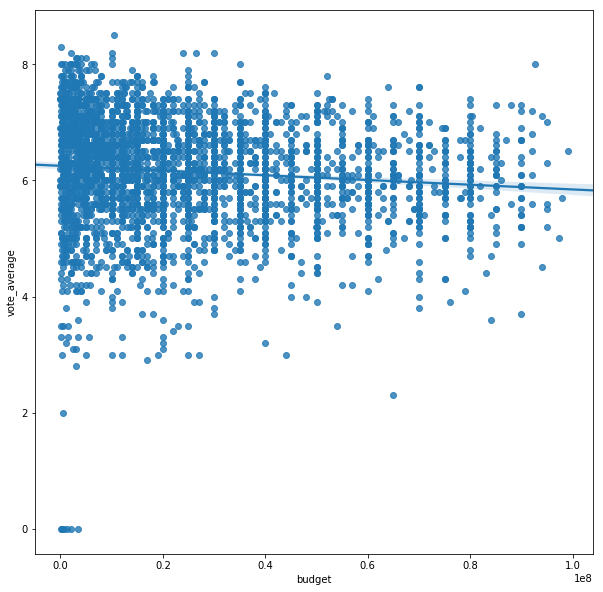

In [14]:
plt.figure(figsize = (10,10))
sns.regplot(x="budget", y="vote_average", data=movies);

In [15]:
movies = movies[movies['budget'] != 0]

C:\Users\jwcn9\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x720 with 0 Axes>

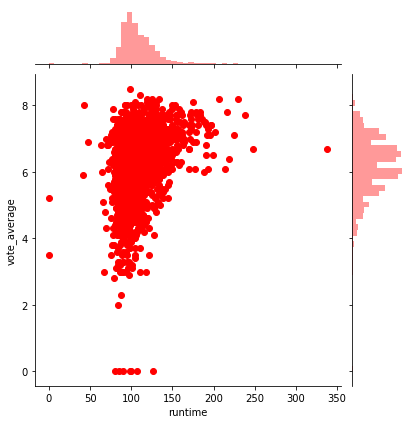

In [16]:
plt.figure(figsize = (10,10))
sns.jointplot(x="runtime", y="vote_average", data=movies, color= 'Red');

C:\Users\jwcn9\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


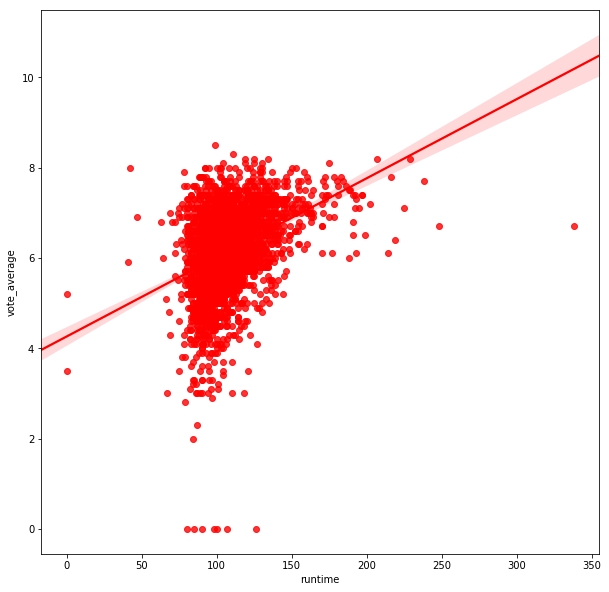

In [17]:
plt.figure(figsize = (10,10))
sns.regplot(x="runtime", y="vote_average", data=movies, color= 'Red');

In [18]:
movies = movies[movies['runtime'] != 0]
movies = movies[movies['vote_average'] != 0]

### Labeling categories

In [19]:
# set range based on describe() function above
bins = pd.IntervalIndex.from_tuples([(0, 6.3), (6.3, 8.5)])

# create list of movie grades and appending them to a new column in movies
movie_grades = pd.cut(movies['vote_average'], 2, labels=[0, 1])
movies['grades'] = movie_grades.astype('category')

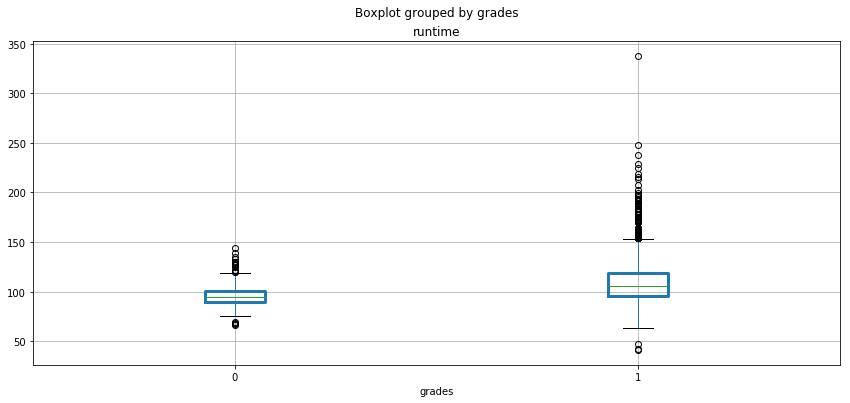

In [20]:
boxprops = dict(linewidth=3)
movies.boxplot(
    column=['runtime'], 
    by='grades',
    boxprops=boxprops, 
    figsize=(14,6), 
    layout=(1,1)
)
plt.show()

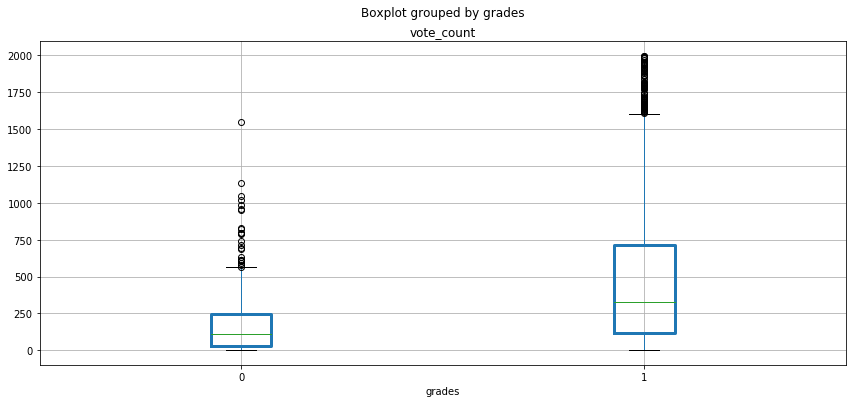

In [21]:
boxprops = dict(linewidth=3)
movies.boxplot(
    column=['vote_count'], 
    by='grades',
    boxprops=boxprops, 
    figsize=(14,6), 
    layout=(1,1)
)
plt.show()

### Modelling Data

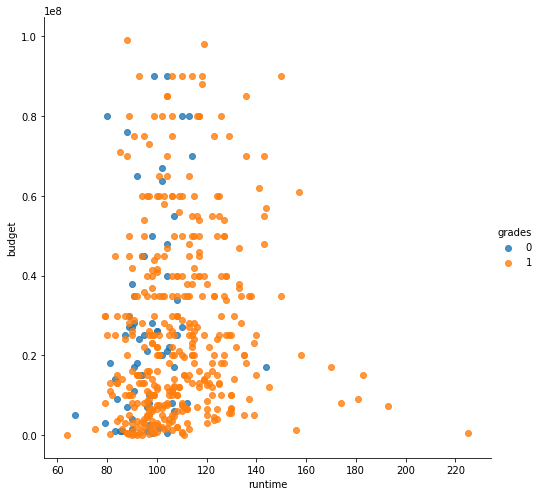

In [22]:
sns.lmplot(x='runtime', y='budget', hue='grades', data=movies.sample(450), fit_reg=False, height=7)
plt.show()

In [23]:
# conclusion, excellent movies generally have higher runtime and lower budget than good movies
movies.dropna(inplace=True)
X = movies[['runtime','budget']]
Y = movies.grades

In [24]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.3, random_state=42)

In [25]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2207, 2) (2207,)
(946, 2) (946,)


### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
from sklearn.model_selection import  cross_val_score

# cv means cross validation
c_dec = cross_val_score(clf, X_train, y_train, cv=10)
c_dec.mean()

0.7738739155016351

In [28]:
result = clf.predict_proba(X_test)[:]
test_result = np.asarray(y_test)

In [32]:
Dec_result = pd.DataFrame(result[:,1])
Dec_result['Predict'] = Dec_result[0].map(lambda s: 1 if s >= 0.6  else 0)
Dec_result['testAnswer'] = pd.DataFrame(test_result)

Dec_result['Correct'] = np.where((Dec_result['Predict'] == Dec_result['testAnswer']), 1, 0)
Dec_result.head()

,0,Predict,testAnswer,Correct
0,1.0,1,1,1
1,1.0,1,1,1
2,1.0,1,1,1
3,1.0,1,1,1
4,1.0,1,0,0


In [33]:
Dec_result.Correct.mean()

0.781183932346723

### Logistic Regression

In [48]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies = movies[['budget', 'runtime', 'popularity', 'vote_count', 'vote_average']]
movies.dropna(inplace=True)

movies['good'] = movies['vote_average'].apply(lambda x: int(x>6.4))
movies.drop('vote_average',axis=1,inplace=True)
movies.head()

,budget,runtime,popularity,vote_count,good
0,237000000,162.0,150.437577,11800,1
1,300000000,169.0,139.082615,4500,1
2,245000000,148.0,107.376788,4466,0
3,250000000,165.0,112.312950,9106,1
4,260000000,132.0,43.926995,2124,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(movies.drop('good',axis=1),
                                                    movies['good'],
                                                    test_size=0.3, random_state=101)

In [50]:
logmodel = LogisticRegression()

In [51]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
pred = logmodel.predict(X_test)

             precision    recall  f1-score   support

          0       0.70      0.65      0.67       862
          1       0.53      0.57      0.55       579

avg / total       0.63      0.62      0.62      1441



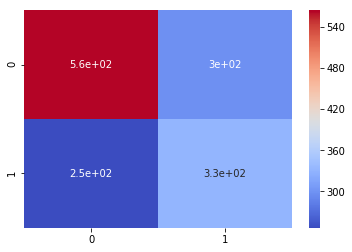

In [53]:
print(classification_report(y_test,pred))
sns.heatmap(confusion_matrix(y_test,pred), annot=True, cmap='coolwarm')